In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
file = "data\\data\\MWData\\MWData\\MW.txt"

records = {"id": [], "event": [], "device": [], "channel": [],"code": [], "size": [], "data": []}

with open(file, "r") as file:
    for line in file:
        parts = line.strip().split("\t")

        id, event, device, channel, code, size, raw_data = parts
        signal = [int(value.strip()) for value in raw_data.split(",")]

        records["id"].append(int(id))
        records["event"].append(int(event))
        records["device"].append(device)
        records["channel"].append(channel)
        records["code"].append(int(code))
        records["size"].append(int(size))
        records["data"].append(signal)

df = pd.DataFrame(records)
df

,id,event,device,channel,code,size,data
0,0,0,MW,FP1,0,1017,"[38, 48, 51, 44, 48, 56, 56, 41, 20, -3, -9, -..."
1,1,1,MW,FP1,1,889,"[83, 74, 65, 65, 66, 55, 43, 25, 18, 20, 26, 3..."
2,2,2,MW,FP1,4,1017,"[19, 10, -2, -9, -5, 3, 8, 7, 8, 2, -10, -21, ..."
3,3,3,MW,FP1,1,1017,"[17, 29, 36, 26, 21, 17, 17, 13, 17, 21, 25, 2..."
4,4,4,MW,FP1,8,952,"[77, 74, 69, 70, 76, 75, 76, 75, 67, 66, 76, 9..."
...,...,...,...,...,...,...,...
67630,67630,67630,MW,FP1,-1,1024,"[138, 135, 123, 96, 59, 38, 11, 16, 44, 67, 70..."
67631,67631,67631,MW,FP1,-1,1024,"[4, 5, -7, -12, -11, -17, 2, 52, 73, 55, 12, -..."
67632,67632,67632,MW,FP1,-1,1024,"[96, 163, 208, 179, 129, 114, 140, 155, 108, 5..."
67633,67633,67633,MW,FP1,-1,1024,"[-30, 4, 53, 85, 84, 72, 80, 85, 65, 23, -26, ..."


In [23]:
# ---FILTER DATASET---
fs = 512
def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyq = 0.5 * fs    # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

df_filtered = df.copy()
df_filtered["data"] = df_filtered["data"].apply(lambda signal: bandpass_filter(signal, 0.5, 50, fs, 4))

df_filtered = df_filtered[df_filtered["code"] != -1].reset_index(drop=True) # Drop columns with code = -1
df_filtered

,id,event,device,channel,code,size,data
0,0,0,MW,FP1,0,1017,"[-3.877180027673125, 3.1553538027777885, 8.943..."
1,1,1,MW,FP1,1,889,"[28.798206454168426, 23.43520535391149, 17.560..."
2,2,2,MW,FP1,4,1017,"[-34.00138480816221, -42.04699332904883, -48.5..."
3,3,3,MW,FP1,1,1017,"[-19.500451437261326, -16.57621539591369, -14...."
4,4,4,MW,FP1,8,952,"[-26.343563299456, -28.281814679438185, -30.01..."
...,...,...,...,...,...,...,...
54929,54929,54929,MW,FP1,0,889,"[7.200086944555191, 6.2837730131132385, 6.4752..."
54930,54930,54930,MW,FP1,9,1015,"[13.54267831323385, 16.14608184824476, 19.4664..."
54931,54931,54931,MW,FP1,1,952,"[-3.6278346715766974, 0.7223717167471166, 4.16..."
54932,54932,54932,MW,FP1,6,1015,"[8.150469402213268, 18.647652718117374, 26.252..."


In [24]:
med_len = int(df_filtered["size"].median())

#---RESAMPLE DATASET---
def resample_dataset(df, fs, med_len):

    for j, data in enumerate(df["data"]):
        data = np.array(data, dtype=float)
        time = np.arange(len(data)) / fs

        valid = ~np.isnan(data)
        clean_data = data[valid]
        clean_time = time[valid]

        interpolator = interpolate.interp1d(clean_time, clean_data, fill_value="extrapolate")
        new_time = np.linspace(clean_time[0], clean_time[-1], med_len)
        resampled_data = interpolator(new_time)

        # Store results
        df.at[j, "data"] = resampled_data
        df.at[j, "size"] = len(resampled_data)

    return df


resample_dataset(df_filtered, fs, med_len)
df_filtered

,id,event,device,channel,code,size,data
0,0,0,MW,FP1,0,953,"[-3.877180027673125, 3.5444507043755014, 9.399..."
1,1,1,MW,FP1,1,953,"[28.798206454168426, 23.79574324300439, 18.350..."
2,2,2,MW,FP1,4,953,"[-34.00138480816221, -42.48193466001921, -49.0..."
3,3,3,MW,FP1,1,953,"[-19.500451437261326, -16.43418903760517, -14...."
4,4,4,MW,FP1,8,953,"[-26.343563299456, -28.279778701097868, -30.01..."
...,...,...,...,...,...,...,...
54929,54929,54929,MW,FP1,0,953,"[7.200086944555191, 6.345373949680765, 6.44952..."
54930,54930,54930,MW,FP1,9,953,"[13.54267831323385, 16.36232736205824, 20.0700..."
54931,54931,54931,MW,FP1,1,953,"[-3.6278346715766974, 0.7178021722215666, 4.16..."
54932,54932,54932,MW,FP1,6,953,"[8.150469402213268, 19.142899809114066, 26.627..."


In [26]:
#---Normalize the dataset---
scaler = MinMaxScaler()

for idx, signal in enumerate(df_filtered["data"]):
    signal_reshaped = signal.reshape(-1, 1)
    scaled_signal = scaler.fit_transform(signal_reshaped)
    scaled_signal = scaled_signal.flatten()
    df_filtered.at[idx, "data"] = scaled_signal

df_filtered

,id,event,device,channel,code,size,data
0,0,0,MW,FP1,0,953,"[0.4890788968493792, 0.5196497656710295, 0.543..."
1,1,1,MW,FP1,1,953,"[0.6612431164363333, 0.6469932428926469, 0.631..."
2,2,2,MW,FP1,4,953,"[0.37998299644039846, 0.34665303842329764, 0.3..."
3,3,3,MW,FP1,1,953,"[0.33383583796863514, 0.3454899037476024, 0.35..."
4,4,4,MW,FP1,8,953,"[0.4416592829380953, 0.4333873950961573, 0.425..."
...,...,...,...,...,...,...,...
54929,54929,54929,MW,FP1,0,953,"[0.6071319683957009, 0.6018743939491993, 0.602..."
54930,54930,54930,MW,FP1,9,953,"[0.5195679365363507, 0.539275235187992, 0.5651..."
54931,54931,54931,MW,FP1,1,953,"[0.40024122010919555, 0.43266358285245055, 0.4..."
54932,54932,54932,MW,FP1,6,953,"[0.602016460270121, 0.6917010490988523, 0.7527..."


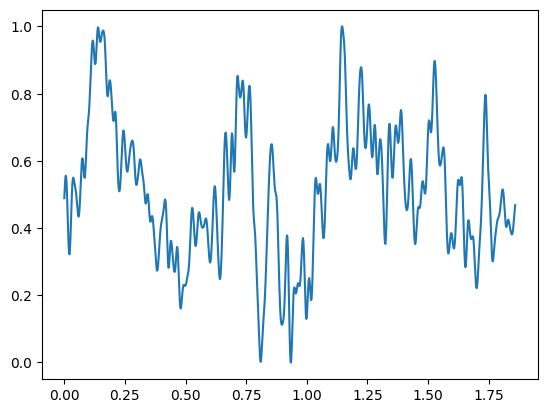

In [27]:
time = np.arange(0, med_len) / fs
plt.plot(time, df_filtered["data"][0])
plt.show()